In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import tensorflow_model_optimization as tfmot

# from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit.default_n_bit_quantize_configs import (
#     NoOpQuantizeConfig,
# )
# from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit.default_n_bit_quantize_registry import (
#     DefaultNBitConvQuantizeConfig,
#     DefaultNBitQuantizeConfig,
# )
# from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit.default_n_bit_quantize_scheme import (
#     DefaultNBitQuantizeScheme,
# )

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle, sys, time
import shutil
import json
from scipy.io import  wavfile
from IPython import display

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from get_dataset import decode_audio, get_label, get_waveform_and_label, \
#                         convert_labels_str2int, convert_to_int16, cast_and_pad, \
#                         convert_dataset, get_preprocess_audio_func, prepare_background_data, \
#                         get_data, count_labels, is_batched

from get_dataset import get_data, get_file_lists, get_data_config

In [4]:
# jupyter will pass an extra -f=<tmp_file> arg, which throws an 
# unrecognized argument error
sys.argv = sys.argv[0:1] 

Flags = util.parse_command()

In [5]:
## Set these for an extra short test just to validate that the code runs
Flags.num_samples_training = 2000
Flags.num_samples_validation = -1  # val,test are not shuffled, so we'll get an unbalanced class if we take only a few
Flags.num_samples_test = -1        # plus, they're not really that big.

Flags.foreground_volume_min = 0.1
Flags.foreground_volume_max = 1.0

load_pretrained_model = True # True to load from a file, False to build/train from scratch
save_model = False

# 'trained_models/str_ww_model.h5' is the default save path for train.py
pretrained_model_path = 'trained_models/str_ww_model.h5' # path to load from if load_pretrained_model is True
# pretrained_model_path = '/Users/jeremy/dev/tiny_mlperf/tiny_main/trained_models/str_ww_model.h5' # path to load from if load_pretrained_model is True


Flags.epochs = 10

In [6]:
Flags.background_volume=1.0 # experimenting
Flags.use_qat = False

In [7]:
try:
    with open('streaming_config.json', 'r') as fpi:
        streaming_config = json.load(fpi)
    Flags.data_dir = streaming_config['speech_commands_path']
except:
    raise RuntimeError("""
        In this directory, copy streaming_config_template.json to streaming_config.json
        and edit it to point to the directories where you have the speech commands dataset
        and (optionally) the MUSAN noise data set.
        """)
Flags.bg_path = Flags.data_dir

In [8]:

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [9]:
# json.dumps({'a':True, 'b':False, 'c':None})
import importlib
importlib.reload(get_dataset)

<module 'get_dataset' from '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/streaming_wakeword/get_dataset.py'>

In [10]:
ds_train, ds_test, ds_val = get_dataset.get_all_datasets(Flags)


About to get val data


2024-07-16 15:54:03.812230: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-16 15:54:03.812257: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-16 15:54:03.812264: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-16 15:54:03.812292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-16 15:54:03.812307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dataset has 195 targets and 9786 unknown samples.
Using 12 repeats of the target set plus  106 target samples
Using 1 repeats of the unkown set plus  0 unknown samples
about to get wave_shape, before for block
about to get wave_shape, in for block
after for block, wave_shape = (12288,)
About to apply preprocessor with 13591 samples
not shuffling
About to get train data
Dataset has 1710 targets and 83133 unknown samples.
Using 0 repeats of the target set plus  360 target samples
Using 0 repeats of the unkown set plus  1440 unknown samples
about to get wave_shape, before for block
about to get wave_shape, in for block
after for block, wave_shape = (16000,)
About to apply preprocessor with 560 samples


2024-07-16 15:54:06.305387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Shuffling with buffers size = 560
About to get test data
Dataset has 195 targets and 10810 unknown samples.
Using 13 repeats of the target set plus  167 target samples
Using 1 repeats of the unkown set plus  0 unknown samples
about to get wave_shape, before for block
about to get wave_shape, in for block
after for block, wave_shape = (16000,)
About to apply preprocessor with 15013 samples
not shuffling
Done building datasets


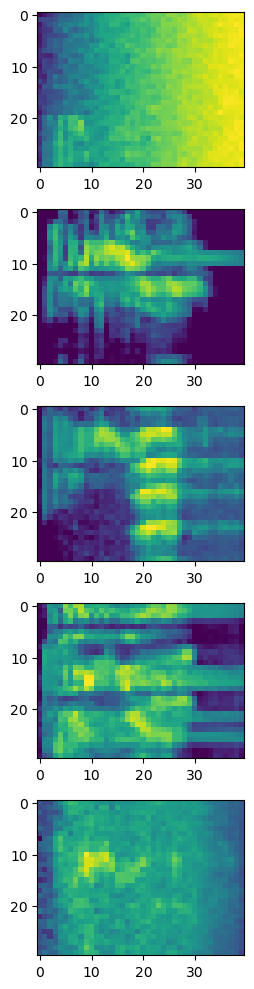

In [11]:
plt.figure(figsize=(10,10))
for i,(x,y) in enumerate(ds_train.unbatch()):
  if i < 5:
    plt.subplot(5,1,i+1)
    plt.imshow(np.squeeze(x))
  else:
    max_val = np.max(x)
plt.tight_layout()
    

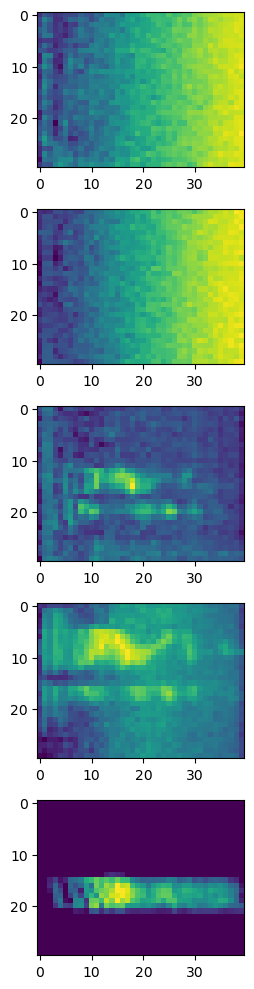

In [12]:
plt.figure(figsize=(10,10))
for i,(x,y) in enumerate(ds_train.unbatch()):
  if i < 5:
    plt.subplot(5,1,i+1)
    plt.imshow(np.squeeze(x))
  else:
    max_val = np.max(x)
plt.tight_layout()
    

In [13]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break


One element from the training set has shape:
Input tensor shape: (30, 1, 40)
Label shape: (3,)
Label : [0. 1. 0.]


These next three cells can be quite slow in the current implementation, so uncomment if you want to see them.
They
1. Create a dataset with only targets if you want to examine those.
2. Show spectra of some target words
3. Count the distribution of classes in the training set

In [14]:
# create a tmp dataset with only the target words
ds_only_target = ds_train.unbatch().filter(lambda x,y: (y[0] == 1.0))
print("Five elements from the only-target set:")
for dat in ds_only_target.take(5):
  print(f"Input tensor shape: {dat[0].shape}")  
  print(f"Label = {dat[1]}; shape = {dat[1].shape}")


Five elements from the only-target set:
Input tensor shape: (30, 1, 40)
Label = [1. 0. 0.]; shape = (3,)
Input tensor shape: (30, 1, 40)
Label = [1. 0. 0.]; shape = (3,)
Input tensor shape: (30, 1, 40)
Label = [1. 0. 0.]; shape = (3,)
Input tensor shape: (30, 1, 40)
Label = [1. 0. 0.]; shape = (3,)
Input tensor shape: (30, 1, 40)
Label = [1. 0. 0.]; shape = (3,)


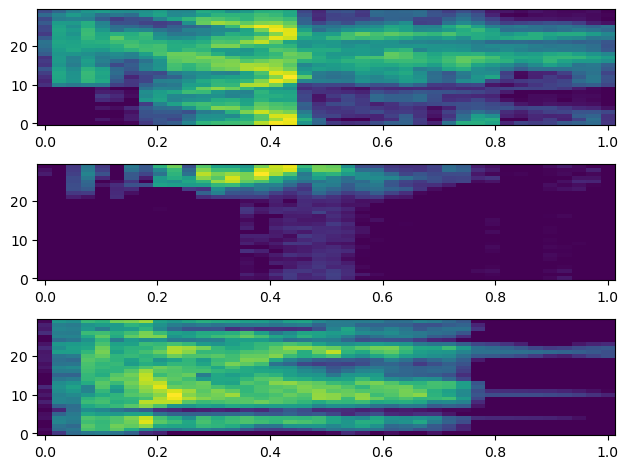

In [15]:
max_target_examples = 3
target_count = 0

plt.Figure(figsize=(10,4))
for dat in ds_train.unbatch():
  # label_string = dat[1].numpy().decode('utf8')
  if np.argmax(dat[1]) == 0:
    target_count += 1
    ax = plt.subplot(max_target_examples, 1, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))

    log_spec = dat[0].numpy().squeeze()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, 1.0, num=width, dtype=float)
    Y = range(height)
    ax.pcolormesh(X, Y, np.squeeze(log_spec))
    if target_count >= max_target_examples:
      break
plt.tight_layout()

In [16]:
## look at the label breakdown in the training set
# print(count_labels(ds_train))

## current count_labels is very slow.  some scratch code here towards
## implementing a faster one by converting labels to one-hot and then summing.
# tf.one_hot(indices, depth)
# ds_1hot = ds_train.map(lambda dat: tf.one_hot(dat[1], 3))
# xx = iter(ds_1hot).next()


## Build and Train Model

In [17]:
# during development, to reload the models module w/o restarting the kernel
# import importlib
# importlib.reload(models)

In [18]:
if load_pretrained_model:
  print(f"Loading pretrained model from {pretrained_model_path}")
  with tfmot.quantization.keras.quantize_scope(): # needed for the QAT wrappers
    model = keras.models.load_model(pretrained_model_path)
else:
  print(f"Building model from scratch")
  model = models.get_model(args=Flags, use_qat=Flags.use_qat) # compile step is done inside get_model()

Loading pretrained model from trained_models/str_ww_model.h5


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1, 40)]       0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 28, 1, 40)         120       
 eConv2D)                                                        
                                                                 
 conv2d (Conv2D)             (None, 28, 1, 128)        5120      
                                                                 
 batch_normalization (Batch  (None, 28, 1, 128)        512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 1, 128)        0         
                                                                 
 dropout (Dropout)           (None, 28, 1, 128)        0     

In [20]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=Flags.epochs)

In [21]:
if save_model:
  model.save('trained_models/str_ww_model_nb.h5')

In [22]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['categorical_accuracy'], train_hist.history['val_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [23]:
## This cell can be slow with QAT enabled
print(f"Eval on training set")
model.evaluate(ds_train)
print(f"Eval on validation set")
model.evaluate(ds_val)
print(f"Eval on test set")
model.evaluate(ds_test)

Eval on training set
6/6 [==============================] - 0s 23ms/step - loss: 0.2283 - categorical_accuracy: 0.8964 - precision: 1.0000 - recall: 0.8778
Eval on validation set
136/136 [==============================] - 76s 554ms/step - loss: 0.2182 - categorical_accuracy: 0.9169 - precision: 0.9544 - recall: 0.8900
Eval on test set
151/151 [==============================] - 4s 27ms/step - loss: 0.0569 - categorical_accuracy: 0.9857 - precision: 0.9894 - recall: 0.9308


[0.056934479624032974,
 0.9857456684112549,
 0.9893784523010254,
 0.9307920336723328]

In [24]:
def build_and_plot_confusion_matrix(model, dataset, label_list=['marvin', 'silent', 'other']):
  model_out = model.predict(dataset)
  model_out = np.squeeze(model_out)
  y_pred_val = np.argmax(model_out, axis=1)
  
  y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
  for i,dat in enumerate(dataset.unbatch()):
    y_true_val[i] = np.argmax(dat[1])
  
  acc = sum(y_pred_val == y_true_val) / len(y_true_val)
  print(f'Validation set accuracy: {acc:.1%}')

  confusion_mtx = tf.math.confusion_matrix(y_true_val, y_pred_val) 
  plt.figure(figsize=(6, 6))
  sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
              annot=True, fmt='g')
  plt.gca().invert_yaxis() # flip so origin is at bottom left
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

6/6 [==============================] - 0s 7ms/step
Validation set accuracy: 49.5%


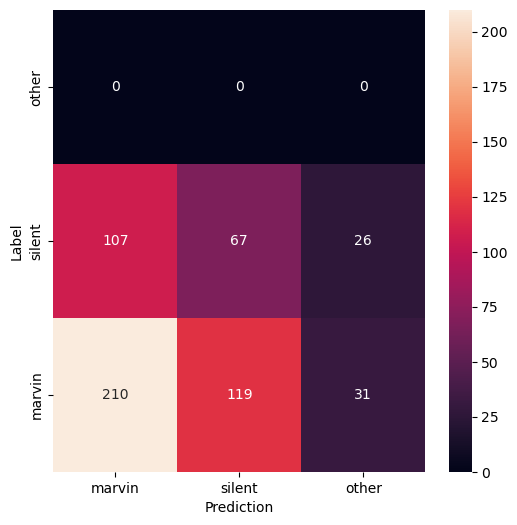

In [25]:
label_list = ['marvin', 'silent', 'other']
# model_out = model.predict(ds_val)
# model_out = np.squeeze(model_out)
# y_pred_val = np.argmax(model_out, axis=1)

# y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
# for i,dat in enumerate(ds_val.unbatch()):
#   y_true_val[i] = np.argmax(dat[1])

# acc = sum(y_pred_val == y_true_val) / len(y_true_val)
# print(f'Validation set accuracy: {acc:.1%}')

build_and_plot_confusion_matrix(model, ds_train)

In [26]:
def ds_to_np(dset):
  x_vals = []
  y_vals = []
  count = 0
  for x,y in dset:
    x_vals.append(x)
    y_vals.append(y)
    count += 1
    if count % 1000 == 0:
      print(f"{count}, ", end="")
  x_vals = np.array(x_vals)
  y_vals = np.array(y_vals)
  print("") # add a newline, since they were suppressed before
  return x_vals, y_vals


In [27]:
x_train, y_train = ds_to_np(ds_train.unbatch())

In [28]:
print(f"Training set class distribution (marvin, silent, other): {np.sum(y_train, axis=0)}")
x_val, y_val = ds_to_np(ds_val.unbatch())
print(f"Validation set class distribution (marvin, silent, other): {np.sum(y_val, axis=0)}")


Training set class distribution (marvin, silent, other): [360. 200.   0.]
1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 
Validation set class distribution (marvin, silent, other): [2446. 1359. 9786.]


(360, 30, 1, 40)


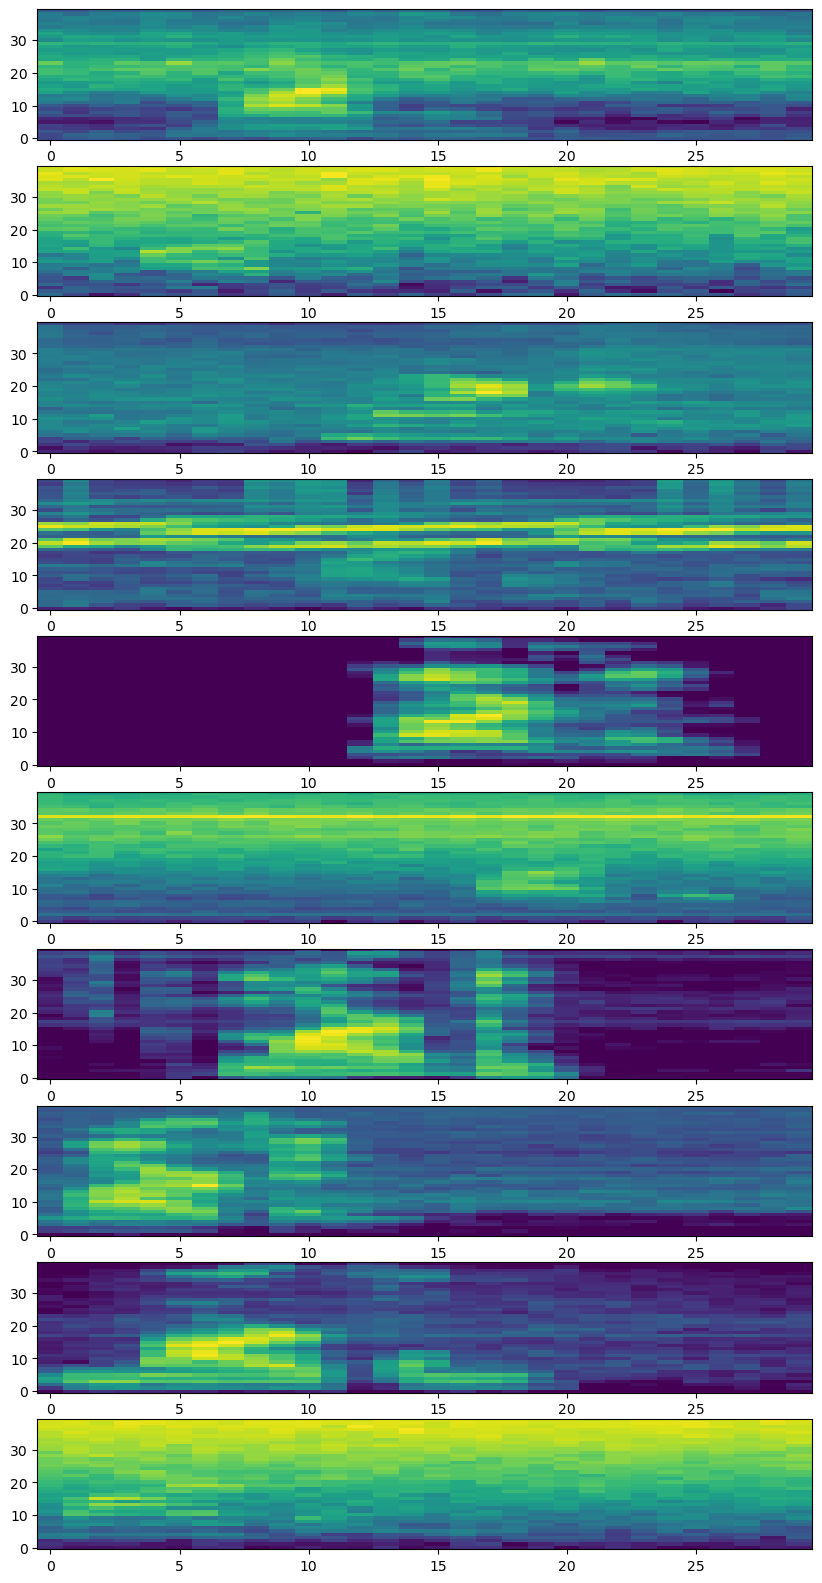

In [29]:
plt.figure(figsize=(10,20))
x_train_pos = x_train[np.nonzero(y_train[:,0])]
print(x_train_pos.shape)
for i in range(10):
  plt.subplot(10,1,i+1)
  plt.imshow(np.squeeze(x_train_pos[i]).T, origin="lower", aspect='auto')

## Post-Training Quantization

In [30]:
num_calibration_steps = 5
tfl_file_name = "strm_ww_int8.tflite"

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if True: 
  # If we omit this block, we'll get a floating-point TFLite model,
  # with this block, the weights and activations should be quantized to 8b integers, 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  ds_calibration = ds_val.unbatch().batch(1).take(num_calibration_steps)
  def representative_dataset_gen():
    for next_spec, label in ds_calibration:
      yield [next_spec] 
    
  converter.representative_dataset = representative_dataset_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # use this one
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

  converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
  converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()

with open(tfl_file_name, "wb") as fpo:
  fpo.write(tflite_quant_model)
print(f"Wrote to {tfl_file_name}")
!ls -l $tfl_file_name

INFO:tensorflow:Assets written to: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpfg0r834i/assets


INFO:tensorflow:Assets written to: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpfg0r834i/assets
/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-07-16 15:55:37.213679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-07-16 15:55:37.213693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-07-16 15:55:37.213915: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmpfg0r834i
2024-07-16 15:55:37.215622: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-16 15:55:37.215627: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/qb/jcjkm0nx4878vyqfj

Wrote to strm_ww_int8.tflite
-rw-r--r--  1 jeremy  staff  74520 Jul 16 15:55 strm_ww_int8.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


#### Test Quantized Interpreter on One Spectrogram

In [31]:
interpreter = tf.lite.Interpreter(model_path=tfl_file_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_data = []
labels = []
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
spec, label = next(ds_val.unbatch().batch(1).take(1).as_numpy_iterator())

spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)
print(f"min = {np.min(spec_q)}, max = {np.max(spec_q)}")

interpreter.set_tensor(input_details[0]['index'], spec_q)
interpreter.invoke()
out_vec = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(out_vec)
out_vec_dequant = (out_vec.astype(np.float32) - output_zero_point)*output_scale

print(f"Output = {out_vec}.")
print(f"True (vs predicted) label = {np.argmax(label)} (vs {pred_label})")
print(f"Dequantized output vector = {out_vec_dequant}")

min = -128, max = 94
Output = [[-106 -128  106]].
True (vs predicted) label = 2 (vs 2)
Dequantized output vector = [[0.0859375 0.        0.9140625]]


#### Now Measure Quantized Accuracy on Validation Set

In [33]:
t0 = time.time(); 
predictions = []
labels = []
# num_test_samples = 100

eval_ds = ds_val # ds_val OR ds_train OR ds_test

for next_spec, next_label in eval_ds.unbatch().batch(1): # .take(num_test_samples):    
  spec_q = np.array(next_spec/input_scale + input_zero_point, dtype=np.int8)
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  predictions.append(np.argmax(interpreter.get_tensor(output_details[0]['index'])))
  labels.append(next_label[0])

predictions = np.array(predictions)
labels = np.argmax(np.array(labels), axis=1)
num_correct = np.sum(labels == predictions)
acc = num_correct / len(labels)
print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")
t1 = time.time(); 
print(f"Measured validation accuracy in {t1-t0} s")

Accuracy = 0.914 (12417/13591)
Measured validation accuracy in 18.906569004058838 s


As of 10 Feb 2024, the quantized accuracy on the training set is 83% and 83% on the validation set.

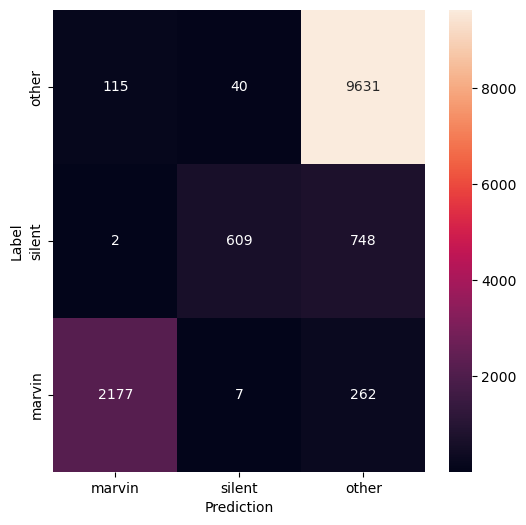

In [34]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run Model on Long Waveform

In [35]:
if streaming_config['musan_path'] is None or len(streaming_config['musan_path']) == 0:
  raise RuntimeError("Stopping before the long-wave test, which requires the musan dataset in streaming_config['musan_path']")

In [36]:
def trim_and_normalize(wav_in, rel_thresh):
  """
  Trims leading and trailing 'quiet' segments, where quiet is defined as 
  less than rel_thresh*max(wav_in).
  Then scales such that RMS of trimmed wav = 1.0
  """
  idx_start = np.min(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  idx_stop  = np.max(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  
  wav_out = wav_in[idx_start:idx_stop]
  wav_out = wav_out / np.std(wav_out) 
  return wav_out

In [37]:
Flags.variable_length=True
model_tv = models.get_model(args=Flags, use_qat=False) # Flags.use_qat)
Flags.variable_length=False
# transfer weights from trained model into variable-length model
model_tv.set_weights(model.get_weights())

DS TCN model for streaming invoked
Using default model config (hard-coded in keras_model.py)
Input shape = [None, 1, 40]
Apple Silicon platform detected. Using legacy adam as standard Keras Adam is slow on this processor.


In [101]:
rel_thresh = 0.05 # trim out leading/trailing space with less than rel_thresh*max(waveform)

model_settings = models.prepare_model_settings(label_count, Flags)
samp_freq = model_settings['sample_rate']

musan_path = streaming_config['musan_path']
if True:
    # bg_file_configs is a list of (path, start-time, stop-time, RMS level) tuples
    bg_file_configs = [
      (musan_path+'/speech/librivox/speech-librivox-0149.wav', 100.0, 300.0, 0.1),
      (musan_path+'/speech/librivox/speech-librivox-0150.wav', 100.0, 300.0, 0.1),
      (musan_path+'/speech/librivox/speech-librivox-0152.wav', 100.0, 300.0, 0.1),
      (musan_path+'/music/hd-classical/music-hd-0002.wav', 300.0, 450.0, 0.5),
      (musan_path+'/music/hd-classical/music-hd-0002.wav', 450.0, 600.0, 0.5),
      (musan_path+'/speech/librivox/speech-librivox-0052.wav', 600.0, 1200.0, 0.5),
    ]
    long_wav_len_sec = 20*60.0
    rng = np.random.default_rng()
    intervals = rng.exponential(scale=7.0, size=(100))
    # intervals < 3 sec may mess up the counting
    intervals = intervals[intervals>3.0]
    insertion_secs = np.cumsum(intervals[:50])
    # This should spread the words out in time, but if the parameters
    # are changed, then double check this.
    insertion_secs *= 595.0/insertion_secs[-1]
    print(f"last word injected at time {insertion_secs[-1]}")
    ww_amplitudes = rng.uniform(low=0.25, high=1.0, size=(len(insertion_secs)))

else:  
    bg_file_configs = [
      (musan_path+'/noise/free-sound/noise-free-sound-0048.wav', 0.0, 10.0, 0.5)
    ]
    long_wav_len_sec = 10.0
    insertion_secs = np.array([1.0, 5.0, 8.0])
    ww_amplitudes = np.array([1.0, 0.5, 0.25])

ww_files = []
for line in open(os.path.join(Flags.data_dir, 'testing_list.txt')):
    if line.split('/')[0] == 'marvin':
        ww_path = os.path.join(Flags.data_dir, line.strip())
        ww_files.append(ww_path)

ww_files = ww_files[:len(insertion_secs)]


last word injected at time 595.0


In [102]:
long_wav = np.zeros(int(long_wav_len_sec*samp_freq), dtype=np.float32)
for bg_path, t_start, t_stop, rms_level in bg_file_configs: 
    bg_sampling_freq, tmp_wav = wavfile.read(bg_path)
    assert bg_sampling_freq == samp_freq
    tmp_wav = tmp_wav[:int((t_stop-t_start)*samp_freq)]
    tmp_wav = rms_level*(tmp_wav / np.std(tmp_wav)) # normalize to RMS=1.0 then scale
    long_wav[int(t_start*samp_freq):int(t_stop*samp_freq)] = tmp_wav

# long_wav = long_wav * 0.0 # uncomment to zero out background noise

ww_present = np.zeros(long_wav.shape)
# ww_windows = [] # list of (start_index,stop_index) tuples bounding each wakeword insertion
for i in range(len(ww_files)):
    ww_sampling_freq, ww_wav = wavfile.read(ww_files[i])
    assert int(ww_sampling_freq) == samp_freq
    index = int(insertion_secs[i] * samp_freq)
    
    ww_wav = trim_and_normalize(ww_wav, rel_thresh)
    assert index+len(ww_wav) < len(long_wav)
    
    long_wav[index:index+len(ww_wav)] += ww_amplitudes[i]*ww_wav
    ww_present[index:index+len(ww_wav)] = 1

    # ww_windows.append((index,index+len(ww_wav)))

data_config_long = get_data_config(Flags, 'training')
data_config_long['foreground_volume_max'] = data_config_long['foreground_volume_min'] = 1.0 # scale to [-1.0,1.0]
data_config_long['background_frequency'] = 0.0 # do not add background noise or time-shift the input
data_config_long['time_shift_ms'] = 0.0
data_config_long['desired_samples']= len(long_wav)

long_wav = long_wav / np.max(np.abs(long_wav)) # scale into [-1.0, +1.0] range
t = np.arange(len(long_wav))/samp_freq

feature_extractor_long = get_dataset.get_preprocess_audio_func(data_config_long)
# the feature extractor needs a label (in 1-hot format), but it doesn't matter what it is
long_spec = feature_extractor_long({'audio':long_wav, 'label':[0.0, 0.0, 0.0]})['audio'].numpy()

print(f"Long waveform shape = {long_wav.shape}, spectrogram shape = {long_spec.shape}")


Long waveform shape = (19200000,), spectrogram shape = (37499, 1, 40)


In [103]:
## scale wav into [-32768, +32767] and cast to int16 for wav file
wavfile.write('long_wav.wav', 16000, (long_wav*(2**15)).astype(np.int16))

In [104]:
yy = model_tv(np.expand_dims(long_spec, 0))[0].numpy()

In [105]:
print(long_wav.shape)
print(ww_present.shape)
importlib.reload(util)

(19200000,)
(19200000,)


<module 'str_ww_util' from '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/streaming_wakeword/str_ww_util.py'>

In function, counted 46 true positives and 4 false negatives.
6 false detections by counting
46 true detections by counting
4 false rejections by counting


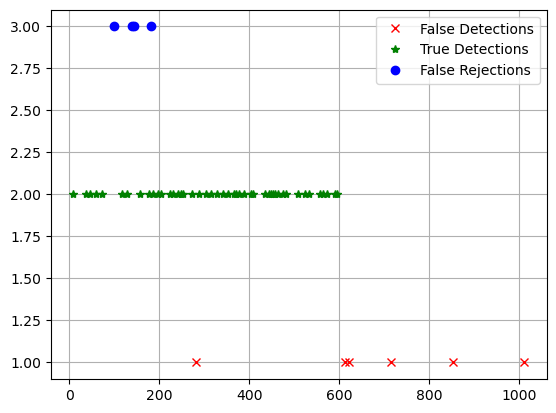

In [107]:
det_thresh = 0.95
## shows detection when wakeword activation is strongest output
# ww_detected_spec_scale = (np.argmax(yy, axis=1)==0) # detections on the time scale of spectrograms

## shows detection when ww activation > thresh
ww_detected_spec_scale = (yy[:,0]>det_thresh).astype(int)
ww_true_detects, ww_false_detects, ww_false_rejects = util.get_true_and_false_detections(ww_detected_spec_scale, ww_present, Flags)

print(f"{np.sum(ww_false_detects!=0)} false detections by counting")
print(f"{np.sum(ww_true_detects!=0)} true detections by counting")
print(f"{np.sum(ww_false_rejects!=0)} false rejections by counting")

plt.plot(t, 1*util.zero2nan(ww_false_detects),   'rx', label='False Detections')
plt.plot(t, 2*(util.zero2nan(ww_true_detects)),  'g*', label='True Detections')
plt.plot(t, 3*(util.zero2nan(ww_false_rejects)), 'bo', label='False Rejections')
plt.legend()
plt.grid(True)

In [99]:
fp_clips_to_show = np.minimum(5, np.sum(ww_false_detects, dtype=np.int32))
for i in range(fp_clips_to_show):
  fp_start = np.nonzero(ww_false_detects)[0][i]
  fp_clip = slice(fp_start-16000,fp_start+16000)
  display.display(display.Audio(long_wav[fp_clip], rate=16000))


added 15616 extra zeros


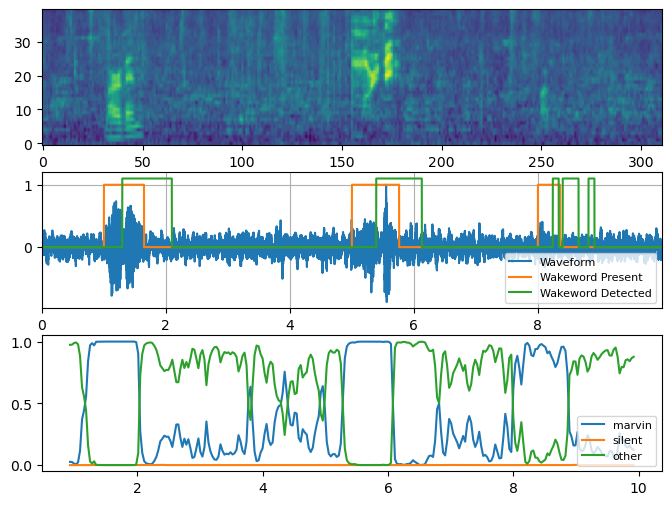

In [100]:
t_spec= np.arange(long_spec.shape[0])*(Flags.window_stride_ms/1000)

ww_detected = np.repeat(ww_detected_spec_scale, Flags.window_stride_ms*Flags.sample_rate/1000)
extra_zeros = np.zeros(len(long_wav)-len(ww_detected))
print(f"added {len(extra_zeros)} extra zeros")
ww_detected = np.concatenate((extra_zeros, ww_detected), axis=0)

plt.figure(figsize=(8, 6))

plt.subplot(3,1,1)
plt.imshow(np.squeeze(long_spec).T, origin="lower", aspect='auto')


plt.subplot(3,1,2)
plt.plot(t, long_wav, t, ww_present, t, 1.1*ww_detected)
plt.xlim([np.min(t), np.max(t)])
plt.grid(True)
plt.legend(['Waveform', 'Wakeword Present', 'Wakeword Detected'], loc='lower right', fontsize=8)

plt.subplot(3,1,3)
plt.plot(t_spec[29:], yy[:])
plt.legend(label_list, loc='lower right', fontsize=8);
# display.display(display.Audio(long_wav, rate=16000))

## Quantized Model on Long Wave

In [46]:
yy_q = np.nan*np.zeros((long_spec.shape[0]-model.input.shape[1]+1,3))
t0 = time.time(); 
preds_q = []
labels = []

for idx in range(long_spec.shape[0]-model.input.shape[1]+1):
  spec = long_spec[idx:idx+input_shape[1],:,:]
  spec = np.expand_dims(spec, 0) # add batch dimension  
  spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)
  
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  yy_q[idx,:] = interpreter.get_tensor(output_details[0]['index'])

# Dequantize so that softmax output is in range [0,1]
yy_q = (yy_q.astype(np.float32) - output_zero_point)*output_scale

t1 = time.time(); 
print(f"Ran quantized model on long wave in {t1-t0:1.2f} s")

Ran quantized model on long wave in 0.41 s


In [47]:
det_thresh = 0.9
## shows detection when wakeword activation is strongest output
# ww_detected_spec_scale = (np.argmax(yy, axis=1)==0) # detections on the time scale of spectrograms

## shows detection when ww activation > thresh
ww_detected_spec_scale = (yy_q[:,0]>det_thresh).astype(int)

ww_true_detects, ww_false_detects, ww_false_rejects = util.get_true_and_false_detections(ww_detected_spec_scale, ww_present, Flags)

print(f"{np.sum(ww_false_detects!=0)} false detections by counting")
print(f"{np.sum(ww_true_detects!=0)} true detections by counting")
print(f"{np.sum(ww_false_rejects!=0)} false rejections by counting")

In function, counted 36 true positives and 14 false negatives.
10 false detections by counting
36 true detections by counting
14 false rejections by counting


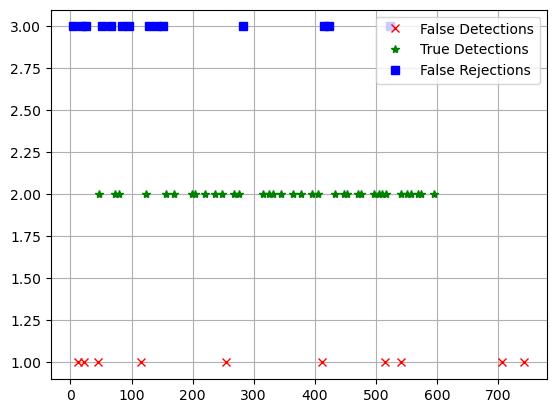

In [48]:
plt.plot(t, 1*util.zero2nan(ww_false_detects),   'rx', label='False Detections')
plt.plot(t, 2*(util.zero2nan(ww_true_detects)),  'g*', label='True Detections')
plt.plot(t, 3*(util.zero2nan(ww_false_rejects)), 'bs', label='False Rejections')
plt.legend()
plt.grid(True)

In [49]:
raise RuntimeError("Not an error -- just stop here")

RuntimeError: Not an error -- just stop here

## Scratch Space
